# ESG Analytics Notebook Examples

Hi there!

This notebook shows basic ways of connecting to the ESG Analytics API and some sample queries that you can make to access our datasets.

The examples included are:
* Time series for a companies ESG Pulse
* Detailed topic analysis for companies ESG Pulse by SASB category
* Selecting a specific topic to do analysis for at the company level
* Analysis of ETF detailed topic pulse

For any inquiries, please email support@esganalytics.io

### Required Imports

In [1]:
import pandas as pd
import requests
import json
from tqdm import tqdm
import math

In [21]:
# Header with authorization for the API. Enter your API key as a string
headers = {"Api-Key": "YOUR API KEY"}

## Company ESG Pulse

In [3]:
company_id = 189984
company_endpoint = "https://api.esganalytics.io/api/company/sentiment/?company_id="+str(company_id)+"&group_by=week"
response = requests.get(company_endpoint, headers=headers).json()

In [5]:
df = pd.DataFrame.from_dict(response)

In [6]:
df.head()

,date,average_sentiment,sent_mov_avg
0,2017-11-06T00:00:00,-0.445646,-0.445646
1,2017-11-13T00:00:00,0.649200,0.101777
2,2017-11-20T00:00:00,0.601700,0.268418
3,2017-11-27T00:00:00,0.997800,0.450763
4,2017-12-04T00:00:00,0.992860,0.559183


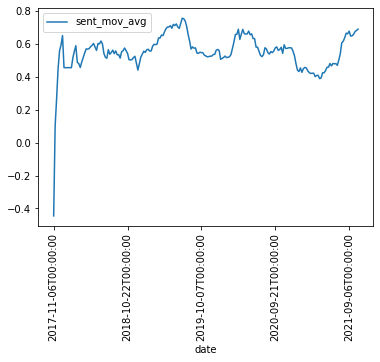

In [7]:
ax = df.plot.line(x='date', y='sent_mov_avg', rot=90)

# Detailed topic analysis for companies ESG Pulse by SASB category

In [8]:
company_id = 189984
company_endpoint = "https://api.esganalytics.io/api/company/nlp/?company_id="+str(company_id)+"&feed_type=flags"
response = requests.get(company_endpoint, headers=headers).json()

In [9]:
df = pd.DataFrame.from_dict(response["data"]["company_ai_flags"])
df.head()

,count,topic,sentiment_avg
0,33,Access & Affordability,0.938033
1,5,Air Quality,0.050380
2,214,Business Ethics,-0.217485
3,209,Business Model Resilience,0.785997
4,225,Competitive Behavior,0.512338


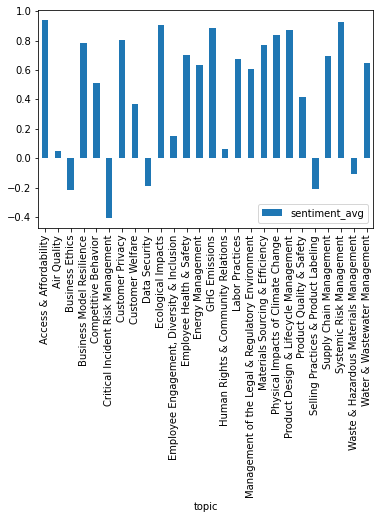

In [10]:
ax = df.plot.bar(x='topic', y='sentiment_avg', rot=90)

In [11]:
company_id = 190724
company_endpoint = "https://api.esganalytics.io/api/company/nlp/?company_id="+str(company_id)+"&feed_type=mini"
response = requests.get(company_endpoint, headers=headers).json()

In [12]:
# The mini feed returns all of the material ESG events, ignoring the full text
df_test = pd.DataFrame.from_dict(response["results"]["analysis"])
df_test.head()

,id,published_at,title,source,source_fk,sentiment_score,sentiment_rank,esg_topics
0,58623589,2021-10-20T01:46:13Z,BMO apologizes after guard asks residential sc...,CBC News,,NaN,None,"[Human Rights & Community Relations, Managemen..."
1,58623021,2021-10-19T14:30:06Z,"CGI Partners with BMO, National Bank of Canada",Yahoo Entertainment,,NaN,None,[Management of the Legal & Regulatory Environm...
2,58616177,2021-10-05T13:40:37Z,"BMO Raises Pay 20% for U.S. Branch, Call-Cente...",Yahoo Entertainment,,0.9886,positive,[Labor Practices]
3,58616171,2021-10-05T12:51:57Z,"BMO Plans 20% Pay Raise for U.S. Branch, Call-...",Bloomberg,,0.9886,positive,[Labor Practices]
4,58615765,2021-09-17T13:00:00Z,Difficult Growing Conditions Mitigated by Crop...,PRNewswire,,0.9975,positive,[Water & Wastewater Management]


In [13]:
company_endpoint = "https://api.esganalytics.io/api/company/nlp/?company_id="+str(company_id)+"&feed_type=mini"
response = requests.get(company_endpoint, headers=headers).json()

In [14]:
tqdm.pandas()
dfs = []

# Pagination is 10 items per page, alternatively you could use the 'next' field to dynamically get the next url
page_count = math.ceil(response["count"]/10)

for i in tqdm(range(1,page_count)):
    #print(i)
    company_endpoint = "https://api.esganalytics.io/api/company/nlp/?company_id="+str(company_id)+"&feed_type=mini&page="+str(i)
    response = requests.get(company_endpoint, headers=headers).json()
    x = pd.DataFrame.from_dict(response["results"]["analysis"])
    dfs.append(x)

df = pd.concat(dfs)

100%|██████████| 21/21 [00:05<00:00,  3.81it/s]


In [15]:
df.head()

,id,published_at,title,source,source_fk,sentiment_score,sentiment_rank,esg_topics
0,58623589,2021-10-20T01:46:13Z,BMO apologizes after guard asks residential sc...,CBC News,,NaN,None,"[Human Rights & Community Relations, Managemen..."
1,58623021,2021-10-19T14:30:06Z,"CGI Partners with BMO, National Bank of Canada",Yahoo Entertainment,,NaN,None,[Management of the Legal & Regulatory Environm...
2,58616177,2021-10-05T13:40:37Z,"BMO Raises Pay 20% for U.S. Branch, Call-Cente...",Yahoo Entertainment,,0.9886,positive,[Labor Practices]
3,58616171,2021-10-05T12:51:57Z,"BMO Plans 20% Pay Raise for U.S. Branch, Call-...",Bloomberg,,0.9886,positive,[Labor Practices]
4,58615765,2021-09-17T13:00:00Z,Difficult Growing Conditions Mitigated by Crop...,PRNewswire,,0.9975,positive,[Water & Wastewater Management]


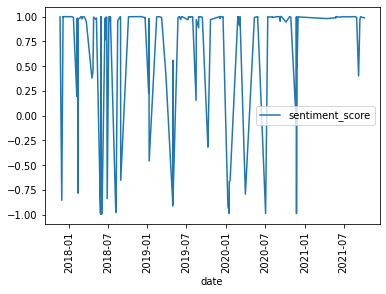

In [16]:
#Filtering the df based on a specific esg topic
topic_df = df[df.esg_topics.apply(lambda x: 'Labor Practices' in x)]

#Creating a date column so that can cluster by day, not timestamp
df['date'] = pd.to_datetime(df['published_at']).dt.date

ax = df.plot.line(x='date', y='sentiment_score', rot=90)

## ETF Topic Pulse

This endpoint allows you to get the detailed topic summaries (AI based ESG sentiment) broken down by SASB category.

In [17]:
etf_detail_endpoint = "https://api.esganalytics.io/api/etf/nlp/?etf_code=DIA&feed_type=etf_flags"
response = requests.get(etf_detail_endpoint, headers=headers).json()

In [18]:
#response = response['data'][0]['etf_ai_flags']
df = pd.DataFrame.from_dict(response['data'][0]['etf_ai_flags'])

In [19]:
df.head()

,count,topic,negative,positive,sentiment_avg
0,764,Access & Affordability,18,746,0.911613
1,314,Air Quality,44,270,0.665378
2,2599,Business Ethics,1114,1485,0.096123
3,3835,Business Model Resilience,425,3410,0.736263
4,3931,Competitive Behavior,1175,2756,0.397200


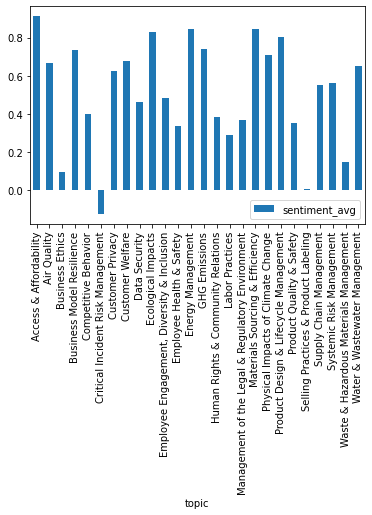

In [20]:
ax = df.plot.bar(x='topic', y='sentiment_avg', rot=90)